# loop registration functional 2p -> anatomy

-over all animals of a folder

Image stack alignment (moving -> fixed)
- For each moving plane, find best (x, y, z, scale) in fixed stack.
- Coarse-to-fine pyramid with template matching + subpixel refinement.
- Outputs per-plane mapping in pixels (x,y) in fixed coords, z index/µm, and scale.

Johannes Larsch 20250918

In [45]:
# Setup & imports
%load_ext autoreload
%autoreload 2
import sys, math, warnings, json
import numpy as np

import os
# --- Batch: average / max projections over all animals ---
from pathlib import Path
import re
import traceback

# Get parent of the notebook dir (project_root)

# Add sibling directory "src" to sys.path

from social_imaging_scripts.registration import align_substack as asu
import saveFunctionalProjections as sfp
from skimage.transform import rotate as sk_rotate

import pandas as pd

import numpy as np
import tifffile as tiff
import nrrd


_HAS_SKIMAGE = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# First generate max and average projections of functional stacks for all animals.

# CONFIG
BASE_FOLDER = Path(r"Y:/07_Data/Matilde")
ANIMAL_NAME_RE = re.compile(r"^L\d+_f\d+$")   # e.g., L331_f01
SUBPATH = Path("02_reg/00_preprocessing/2p_functional/02_motionCorrected")
rotation_angle = 0.0  # change as needed

processed = 0
skipped_missing = 0
skipped_empty = 0
skipped_done = 0
failed = 0

print(f"Base: {BASE_FOLDER}")

if not BASE_FOLDER.exists():
    raise FileNotFoundError(f"BASE_FOLDER does not exist: {BASE_FOLDER}")

# Find animal folders directly under BASE_FOLDER
animal_dirs = [p for p in BASE_FOLDER.iterdir() if p.is_dir() and ANIMAL_NAME_RE.match(p.name)]
animal_dirs.sort(key=lambda p: p.name)


print(f"Found {len(animal_dirs)} animal folder(s):")
for p in animal_dirs:
    print("  -", p.name)

for animal_dir in animal_dirs:
    start_folder = animal_dir / SUBPATH
    animal_name = animal_dir.name  # e.g. "L331_f01"
    if not start_folder.exists():
        print(f"[SKIP:missing] {animal_dir.name} -> {start_folder} (not found)")
        skipped_missing += 1
        continue

    # If already processed, skip
    out_dir = start_folder / "projections"
    max_path = out_dir / f"{animal_name}_max_projections.tif"
    avg_path = out_dir / f"{animal_name}_avg_projections.tif"

    if max_path.exists() and avg_path.exists():
        print(f"[SKIP:done]    {animal_dir.name} (already processed)")
        skipped_done += 1
        continue

    # Optionally, skip if no TIFFs present
    tiffs = [p for p in start_folder.iterdir() if p.is_file() and p.suffix.lower() in {".tif", ".tiff"}]
    if len(tiffs) == 0:
        print(f"[SKIP:empty]   {animal_dir.name} -> {start_folder} (no .tif/.tiff files)")
        skipped_empty += 1
        continue

    print(f"[PROCESS]      {animal_dir.name} -> {start_folder}  (files: {len(tiffs)})")
    try:
        
        sfp.save_max_avg_projections(
        start_folder,
        angle_deg=rotation_angle,
        animal_name=animal_name
    )
        processed += 1
    except Exception as e:
        failed += 1
        print(f"[ERROR] {animal_dir.name}: {e}")
        traceback.print_exc(file=sys.stdout)

print("\n--- Summary ---")
print(f"Processed:       {processed}")
print(f"Skipped done:    {skipped_done}")
print(f"Skipped missing: {skipped_missing}")
print(f"Skipped empty:   {skipped_empty}")
print(f"Failed:          {failed}")

Base: Y:\07_Data\Matilde
Found 7 animal folder(s):
  - L331_f01
  - L395_f06
  - L395_f10
  - L395_f11
  - L427_f01
  - L427_f02
  - L427_f03
[SKIP:done]    L331_f01 (already processed)
[SKIP:done]    L395_f06 (already processed)
[SKIP:done]    L395_f10 (already processed)
[SKIP:done]    L395_f11 (already processed)
[SKIP:done]    L427_f01 (already processed)
[SKIP:done]    L427_f02 (already processed)
[SKIP:empty]   L427_f03 -> Y:\07_Data\Matilde\L427_f03\02_reg\00_preprocessing\2p_functional\02_motionCorrected (no .tif/.tiff files)

--- Summary ---
Processed:       0
Skipped done:    6
Skipped missing: 0
Skipped empty:   1
Failed:          0


In [48]:
# --- Batch: registration of avg_projections to anatomy per animal (fixed = .nrrd, strict) ---

FUNC_SUBPATH = Path(r"02_reg/00_preprocessing/2p_functional/02_motionCorrected")
ANAT_SUBPATH = Path(r"02_reg/00_preprocessing/2p_anatomy")
OUT_SUBPATH  = Path(r"02_reg/07_2pf-a")

REG_KW = dict(
    fixed_z_spacing_um=1.0,
    scale_range=(0.65, 1.05),
    n_scales=20,
    pyramid_downscale=2,
    pyramid_min_size=120,
    z_stride_coarse=1,
    z_refine_radius=5,
    verbose=True,
    do_subpixel=False,  # <<< skip subpixel entirely
)

OVERWRITE_PER_ANIMAL_CSV = False  # set False to skip animals with existing per-animal CSV
COMBINED_CSV_NAME = "combined_registration_log.csv"

# Toggle: mirror fixed stack left–right after axis-fix
FLIP_FIXED_HORIZONTALLY = True  # set False to disable

def _qual_from_ncc(ncc: float) -> str:
    return "good" if ncc >= 0.60 else ("ok" if ncc >= 0.45 else "poor")

def read_good_nrrd_uint8(path: Path, flip_horizontal: bool = False) -> np.ndarray:
    """
    Read 3D NRRD as uint8 with your axis handling:
      im = nrrd.read(f)[0].astype(np.uint8)
      im = np.moveaxis(im, 2, 0); im = np.moveaxis(im, 1, 2)
    """
    data, _ = nrrd.read(str(path))
    im = np.asarray(data, dtype=np.uint8, order="C")
    if im.ndim != 3:
        raise ValueError(f"Expected 3D NRRD; got shape {im.shape} for {path}")
    im = np.moveaxis(im, 2, 0)
    im = np.moveaxis(im, 1, 2)
    if flip_horizontal:
        im = im[:, :, ::-1]  # flip X
    return im  # (Z, Y, X) uint8

print(f"Base: {BASE_FOLDER}")
if not BASE_FOLDER.exists():
    raise FileNotFoundError(f"BASE_FOLDER does not exist: {BASE_FOLDER}")

animal_dirs = [p for p in BASE_FOLDER.iterdir() if p.is_dir() and ANIMAL_NAME_RE.match(p.name)]
animal_dirs.sort(key=lambda p: p.name)
print(f"Found {len(animal_dirs)} animal folder(s).")

combined_rows = []
processed = skipped_missing_inputs = skipped_ambiguous = skipped_existing = failed = 0

for animal_dir in animal_dirs:
    animal = animal_dir.name
    func_start = animal_dir / FUNC_SUBPATH
    anat_dir   = animal_dir / ANAT_SUBPATH
    out_dir    = animal_dir / OUT_SUBPATH
    out_dir.mkdir(parents=True, exist_ok=True)

    per_animal_csv = out_dir / f"{animal}_registration_results.csv"
    if per_animal_csv.exists() and not OVERWRITE_PER_ANIMAL_CSV:
        print(f"[SKIP:exists] {animal}: {per_animal_csv.name}")
        skipped_existing += 1
        try:
            df_prev = pd.read_csv(per_animal_csv)
            if "ncc_score" in df_prev.columns and len(df_prev):
                comb = dict(
                    animal=animal,
                    n_planes=int(df_prev.shape[0]),
                    ncc_mean=float(np.nanmean(df_prev["ncc_score"])),
                    ncc_median=float(np.nanmedian(df_prev["ncc_score"])),
                    ncc_min=float(np.nanmin(df_prev["ncc_score"])),
                    ncc_max=float(np.nanmax(df_prev["ncc_score"])),
                )
                comb["quality"] = _qual_from_ncc(comb["ncc_mean"])
                combined_rows.append(comb)
        except Exception as e:
            print(f"  [WARN] Could not load existing CSV for combined log: {e}")
        continue

    # moving (strict)
    proj_dir = func_start / "projections"
    moving_p = proj_dir / f"{animal}_avg_projections.tif"
    if not moving_p.exists():
        print(f"[SKIP:missing] {animal}: missing moving '{moving_p.name}' in {proj_dir}")
        skipped_missing_inputs += 1
        continue

    # fixed (strict): exactly one .nrrd starting with animal

    if not anat_dir.exists():
        print(f"[SKIP:missing] {animal}: anatomy dir not found -> {anat_dir}")
        skipped_missing_inputs += 1
        continue

    fixed_matches = sorted(anat_dir.glob(f"{animal}*.nrrd"))
    if len(fixed_matches) == 0:
        print(f"[SKIP:missing] {animal}: no fixed NRRD starting with '{animal}' in {anat_dir}")
        skipped_missing_inputs += 1
        continue

    if len(fixed_matches) > 1:
        # filter for 'GCaMP' (case-insensitive)
        gcamp_matches = [p for p in fixed_matches if "gcamp" in p.name.lower()]
        if len(gcamp_matches) == 1:
            fixed_p = gcamp_matches[0]
            print(f"[NOTE] {animal}: multiple fixed NRRDs found, picked '{fixed_p.name}' (contains 'GCaMP')")
        elif len(gcamp_matches) > 1:
            names = ", ".join(p.name for p in gcamp_matches[:5])
            more = "" if len(gcamp_matches) <= 5 else f" (+{len(gcamp_matches)-5} more)"
            print(f"[SKIP:ambiguous] {animal}: multiple 'GCaMP' candidates: {names}{more}")
            skipped_ambiguous += 1
            continue
        else:
            names = ", ".join(p.name for p in fixed_matches[:5])
            more = "" if len(fixed_matches) <= 5 else f" (+{len(fixed_matches)-5} more)"
            print(f"[SKIP:ambiguous] {animal}: {len(fixed_matches)} candidates but none with 'GCaMP': {names}{more}")
            skipped_ambiguous += 1
            continue
    else:
        fixed_p = fixed_matches[0]

    print(f"[PROCESS] {animal}")
    print(f"  moving: {moving_p.name}")
    print(f"  fixed : {fixed_p.name} (flipX={FLIP_FIXED_HORIZONTALLY})")

    try:
        fixed_stack  = read_good_nrrd_uint8(fixed_p, flip_horizontal=FLIP_FIXED_HORIZONTALLY)  # (Z,Y,X) uint8
        moving_stack = tiff.imread(str(moving_p))  # (Zm, Ym, Xm)

        df_results = asu.register_moving_stack(
            fixed_stack,  # uint8 is OK; function converts to float32 internally
            moving_stack,
            animal_id=animal,    # pass the string like "L395_f06"
            **REG_KW,
        )

        df_results.to_csv(per_animal_csv, index=False)
        print(f"  [SAVED] {per_animal_csv}")
        processed += 1

    except Exception as e:
        failed += 1
        print(f"[ERROR] {animal}: {e}")
        traceback.print_exc(file=sys.stdout)



Base: Y:\07_Data\Matilde
Found 7 animal folder(s).
[SKIP:exists] L331_f01: L331_f01_registration_results.csv
[SKIP:exists] L395_f06: L395_f06_registration_results.csv
[SKIP:exists] L395_f10: L395_f10_registration_results.csv
[SKIP:exists] L395_f11: L395_f11_registration_results.csv
[NOTE] L427_f01: multiple fixed NRRDs found, picked 'L427_f01_anatomy_2P_GCaMP.nrrd' (contains 'GCaMP')
[PROCESS] L427_f01
  moving: L427_f01_avg_projections.tif
  fixed : L427_f01_anatomy_2P_GCaMP.nrrd (flipX=True)

=== Registering moving plane 0/4 ===
[Coarse] best @ level 0 -> z=140, yx=(55.0,35.0), s=0.650, ncc=0.6369
[Refine L1] no in-bounds improvement; keeping previous best
[Refine L1] z=140, yx=(55.0,35.0), s=0.650, ncc=0.6369
[Refine L2] no in-bounds improvement; keeping previous best
[Refine L2] z=140, yx=(55.0,35.0), s=0.650, ncc=0.6369
[Final] z=140, yx=(220.00,140.00), s=0.650, ncc=0.4373 (int)

=== Registering moving plane 1/4 ===
[Coarse] best @ level 0 -> z=140, yx=(54.0,36.0), s=0.650, ncc=0

In [ ]:
# write combined log (simple aggregation based on per-animal CSVs)
agg, big = asu.write_combined_log(
    BASE_FOLDER,
    out_csv=BASE_FOLDER / COMBINED_CSV_NAME,
    out_full_csv=BASE_FOLDER / "combined_registration_full.csv"
)

# Show the summary directly in notebook
print()
print(agg.to_string(index=False))

print("\n--- Summary ---")
print(f"Processed:                 {agg.shape[0]}")
print(f"Skipped (missing inputs):  {skipped_missing_inputs}")
print(f"Skipped (ambiguous fixed): {skipped_ambiguous}")
print(f"Skipped (existing CSV):    {skipped_existing}")
print(f"Failed:                    {failed}")


In [50]:
#Interactively view one registration result
pickAnimal = "L427_f01" #which animal to show   
rot_deg = 140 #rotation for display e.g. 140 degrees

BASE_FOLDER = Path(r"Y:/07_Data/Matilde")

def view_registration(animal: str):
    # paths
    animal_dir   = BASE_FOLDER / animal
    anat_dir     = animal_dir / "02_reg/00_preprocessing/2p_anatomy"
    func_projdir = animal_dir / "02_reg/00_preprocessing/2p_functional/02_motionCorrected/projections"
    out_dir      = animal_dir / "02_reg/07_2pf-a"

    fixed_p   = next(anat_dir.glob(f"{animal}*.nrrd"))
    moving_p  = func_projdir / f"{animal}_avg_projections.tif"
    results_p = out_dir / f"{animal}_registration_results.csv"

    # load
    fixed_stack  = read_good_nrrd_uint8(fixed_p, flip_horizontal=True)
    moving_stack = tiff.imread(str(moving_p))
    df_results   = pd.read_csv(results_p)

    # visualize
    asu.interactive_checker(fixed_stack, moving_stack, df_results, rot_deg=rot_deg)

view_registration(pickAnimal)

Output()

[PLOT] L331_f01 (moving plane 2)


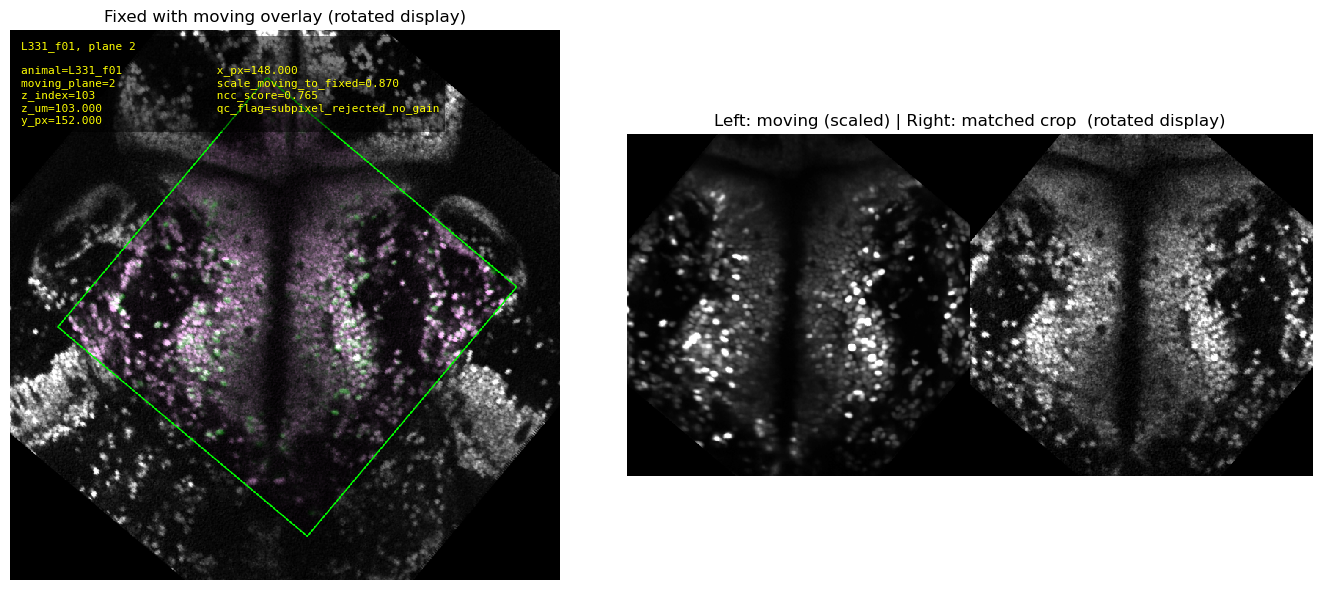

[PLOT] L395_f06 (moving plane 2)


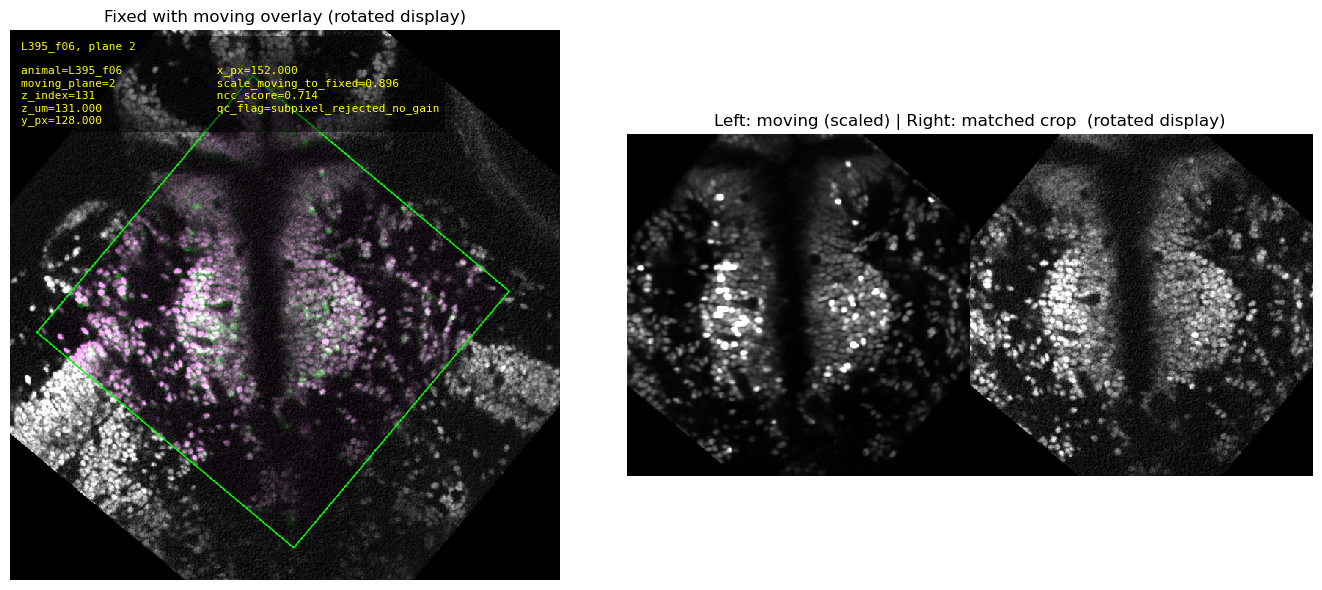

[PLOT] L395_f10 (moving plane 2)


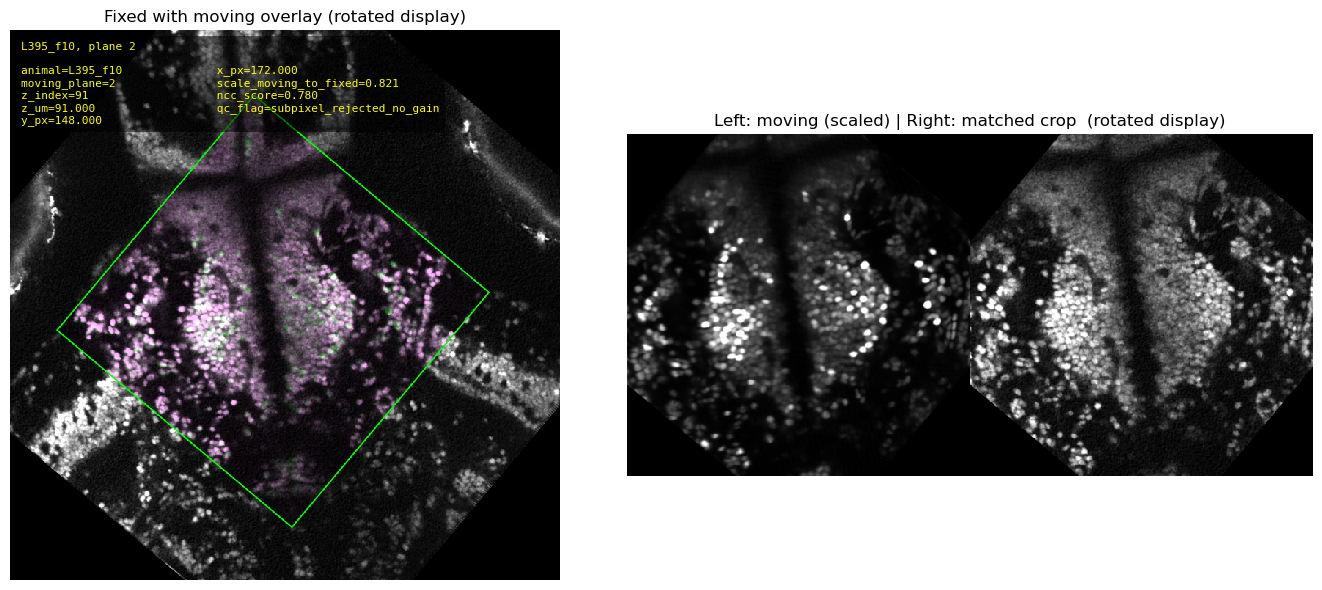

[PLOT] L395_f11 (moving plane 2)


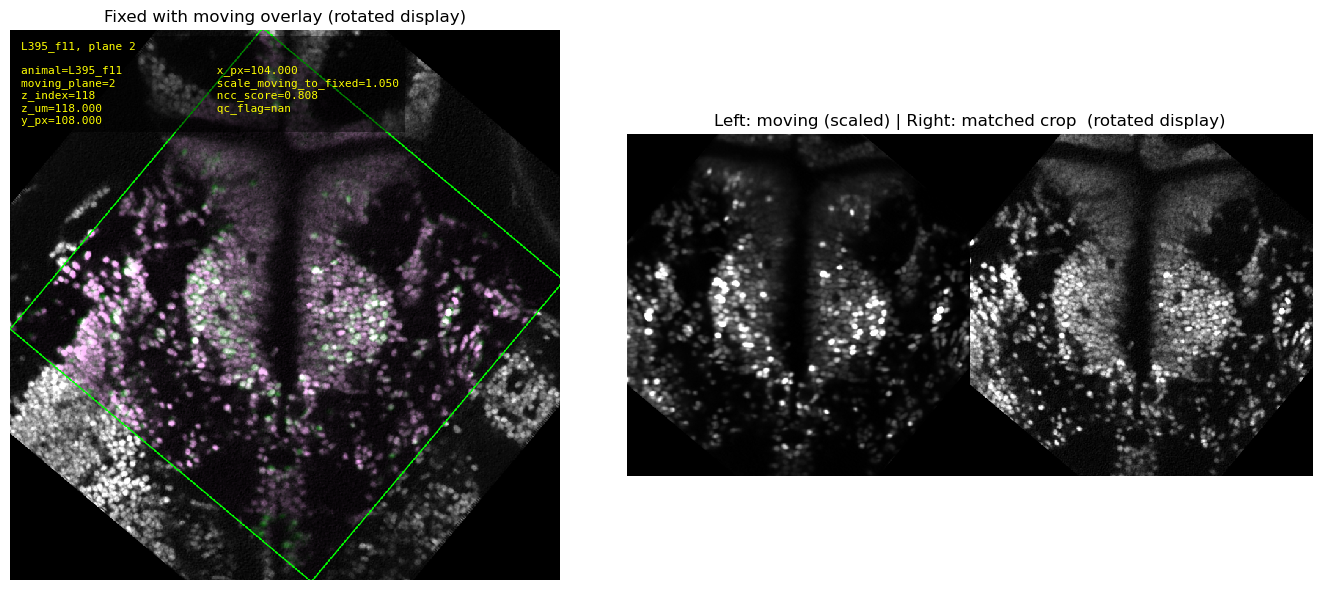

[PLOT] L427_f01 (moving plane 2)


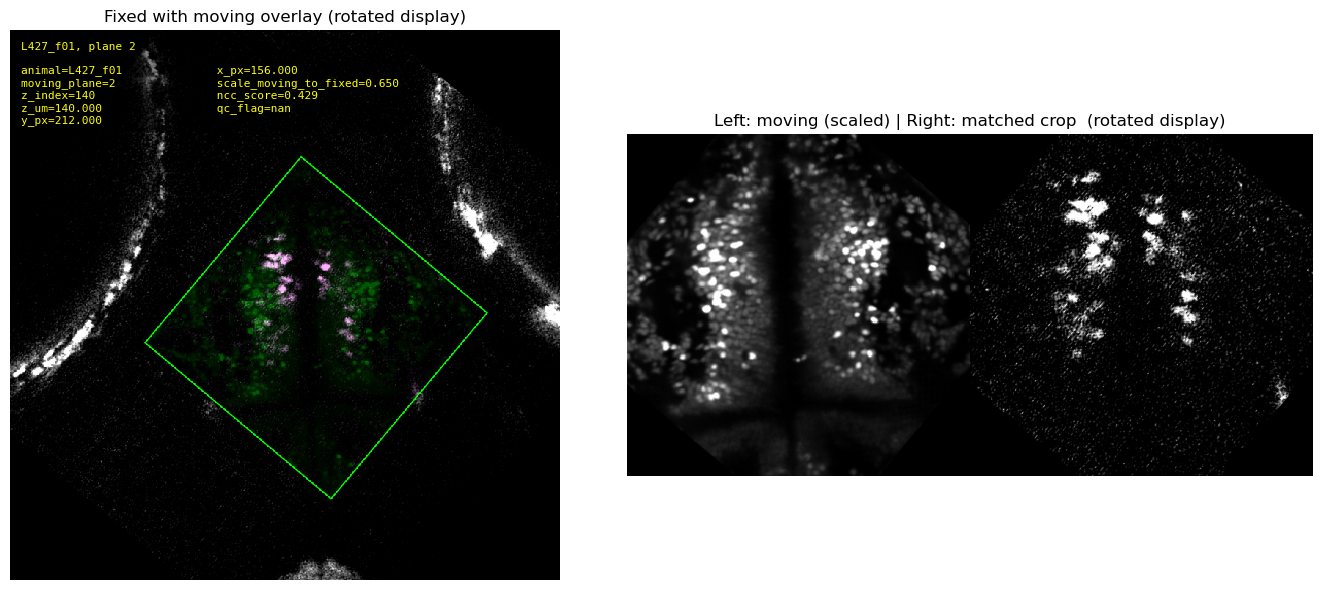

[PLOT] L427_f02 (moving plane 2)


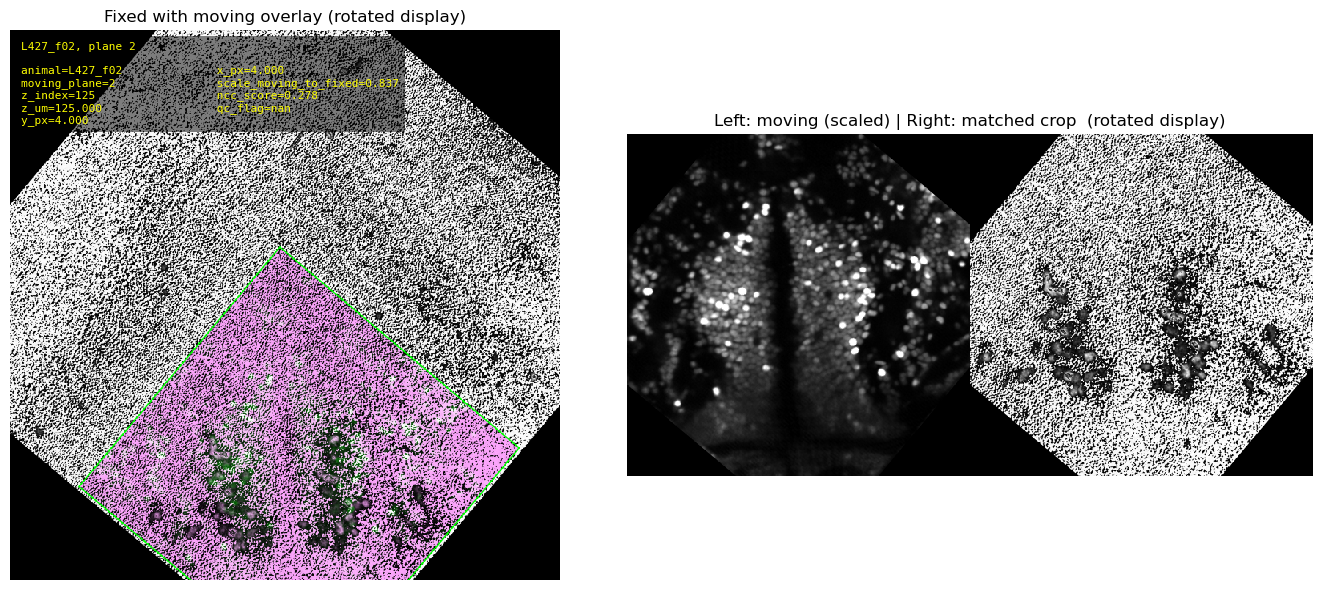

[SKIP] L427_f03: [Errno 2] No such file or directory: '\\\\nasdcsr.unil.ch\\RECHERCHE\\FAC\\FBM\\CIG\\jlarsch\\default\\D2c\\07_Data\\Matilde\\L427_f03\\02_reg\\00_preprocessing\\2p_functional\\02_motionCorrected\\projections\\L427_f03_avg_projections.tif'


In [49]:
#Statically view registration results (single plane) for all animals

rot_deg = 140 #rotation for display e.g. 140 degrees
plane = 2 #which plane to show

BASE_FOLDER = Path(r"Y:/07_Data/Matilde")

def view_registration_static(animal: str, plane: int = 1):
    # paths
    animal_dir   = BASE_FOLDER / animal
    anat_dir     = animal_dir / "02_reg/00_preprocessing/2p_anatomy"
    func_projdir = animal_dir / "02_reg/00_preprocessing/2p_functional/02_motionCorrected/projections"
    out_dir      = animal_dir / "02_reg/07_2pf-a"

    fixed_p   = next(anat_dir.glob(f"{animal}*.nrrd"))
    moving_p  = func_projdir / f"{animal}_avg_projections.tif"
    results_p = out_dir / f"{animal}_registration_results.csv"

    # load
    fixed_stack  = read_good_nrrd_uint8(fixed_p, flip_horizontal=True)
    moving_stack = tiff.imread(str(moving_p))
    df_results   = pd.read_csv(results_p)

    # visualize plane 1 (or whichever is requested)
    print(f"[PLOT] {animal} (moving plane {plane})")
    asu.show_match(fixed_stack, moving_stack, df_results, moving_index=plane, rot_deg=rot_deg)


# Example: run for all animals in BASE_FOLDER (one plot each, plane 1)
for animal_dir in BASE_FOLDER.iterdir():
    if animal_dir.is_dir() and "_" in animal_dir.name:
        try:
            view_registration_static(animal_dir.name, plane = plane)
        except Exception as e:
            print(f"[SKIP] {animal_dir.name}: {e}")